In [261]:
import pandas as pd
import numpy as np
from operator import itemgetter
import pickle
import json
from collections import OrderedDict

import pymorphy2 
import gensim

from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy import spatial

from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
import time

### Загрузка данных для тестирования моделей

In [312]:
data = pd.read_csv('./data/hj.csv')

In [313]:
data[data['word1']=='начало']

,word1,word2,sim
220,начало,матч,0.242424
369,начало,год,0.303030


In [318]:
data = data.sort_values(['sim'], ascending=0)
data.reindex(range(len(data)))
print

In [319]:
y = data['sim'].values
data = data.drop(['sim'], axis=1)

### Определение части речи при помощи Pymorphy2

In [5]:
class NormalAnalyzer:
    __stemmer = pymorphy2.MorphAnalyzer()
    __cache = {}
    
    __grammars = {'NOUN': '_NOUN',
                'VERB': '_VERB', 'INFN': '_VERB', 'GRND': '_VERB', 'PRTF': '_VERB', 'PRTS': '_VERB',
                'ADJF': '_ADJ', 'ADJS': '_ADJ',
                'ADVB': '_ADV'}
    
    __grammars_keys = __grammars.keys()
    
    def norm(self, token):
        token = token.strip().decode('utf-8')
        
        norm = ''
        if token not in self.__cache:
            
            if token == u'джин':
                self.__cache[token] = u'джин_NOUN'
                return u'джин_NOUN'
            elif token == u'планета':
                self.__cache[token] = u'планета_NOUN'
                return u'планета_NOUN'
            elif token == u'дурдом':
                self.__cache[token] = u'дурдом_NOUN'
                return u'дурдом_NOUN'
            elif token == u'начало':
                self.__cache[token] = u'начало_NOUN'
                return u'начало_NOUN'
            elif token == u'подписать':
                self.__cache[token] = u'подписывать_VERB'
                return u'подписывать_VERB'
            elif token == u'заключенный':
                self.__cache[token] = u'заключенный_ADJ'
                return u'заключенный_ADJ'
    
            res = self.__stemmer.parse(token)
            list_POS = [form.tag.POS for form in res]
            res = res[0]
            norm = res.normal_form.replace(u'ё', u'е').replace('c', u'с')
            if 'NUMR' in list_POS:
                norm = norm + '_' + 'NUM'
            elif res.tag.POS in self.__grammars_keys:
                norm = norm + self.__grammars[res.tag.POS]
            else: 
                norm = norm + '_' + 'UNKN'
            self.__cache[token] = norm
        else :
            norm = self.__cache[token]
        return norm
    
normal_analizer = NormalAnalyzer()

In [6]:
def clean_word(word):
    return word.split('_')[0]

### Подсчет расхождений полученных предсказаний и значений данного датасета

Используемые метрики:
$$MSE=\frac{1}{n}\sum_{i=1}^{n}({predict}_{i}-y_i)^{2}$$

$$SpearmanrCorrelation=1-\frac{\sum_{}^{} d^2}{n(n^2 - 1)}$$
<p><center>где $d$ - сумма квадратов разностей рангов, $n$ - число парных наблюдений </center>

In [7]:
# __ Предварительная нормализация полученных списков результатов __
def accuracy_norm(predict, y):
    predict = (predict - min(predict)) / (max(predict) - min(predict))
    y = y / max(y)
    return mean_squared_error(predict, y)

In [8]:
def accuracy(predict, y):
    return mean_squared_error(predict, y)

### Некоторые функции печати

In [9]:
# __ Печать списка ненайденных пар __
def print_undefined(undefinded):
    if len(undefinded) != 0:
        print "Список ненайденных пар:\n"
        for words in undefinded:
            print clean_word(words[0]) + ' - ' + clean_word(words[1])
    print '\nВсего не найдено: %d' %len(undefinded)

In [10]:
# __ Печать ошибки по используемой метрике MSE __
def print_accuracy(predict, y):
    print "Нормализованные предсказания: "
    print accuracy_norm(predict, y) 
    print 
    print "Абсолютные предсказания: "
    print accuracy(predict, y) 
    print
    print "Spearman rank correlation: "
    print spearmanr(predict, y).correlation

### Функции для тестирования

In [11]:
# __ По массиву значений возвращает список позиций в упорядоченном массиве __
def position_in_ordered_list(array):
    array_index = zip(array, range(len(array)))
    sorted_array_index = sorted(array_index, key=itemgetter(0), reverse=True)
    return np.array(zip(*sorted_array_index)[1])

In [433]:
def differ_positions(ar1, ar2):
    set_y = set()
    for y in ar1:
        set_y.add(y)
    set_y = sorted(set_y, reverse=True)
    groups = OrderedDict()
    for y in set_y:
        groups[y] = []
        
    for i, value in enumerate(ar2):
        groups[ar1[i]].append(value)
    
    total = []
    for values in groups.values():
        total.extend(values)
        
    return abs(position_in_ordered_list(ar1) - position_in_ordered_list(ar2))

In [12]:
# __ Предсказания данных (data) моделью (model) __
# ____ Output: predict - список предсказаний
#              undefinded - список объектов, которые невозможно предсказать 

def predict(model, data):
    predict = []
    undefinded = []
    for item in data.values:
        word1 = normal_analizer.norm(item[0])
        word2 = normal_analizer.norm(item[1])
        try:
            predict.append(model.similarity(word1, word2))
        except:
            undefinded.append([word1, word2])
            predict.append(0)
    return predict, undefinded

In [13]:
def predict_myModel(model, data):
    predict = []
    undefinded = []
    for item in data.values:
        word1 = normal_analizer.norm(item[0]).split('_')[0].upper().encode('utf-8')
        word2 = normal_analizer.norm(item[1]).split('_')[0].upper().encode('utf-8')
        try:
            predict.append(model.similarity(word1, word2))
        except:
            undefinded.append([word1, word2])
            predict.append(0)
    return predict, undefinded

In [429]:
# __ Построение графиков: гистограмма по MSE, 
#                         гистограмма по абсолютной ошибке 
# __

def plot_graphs(predict, y):
    param_weight = 0.4
    param_bins_MSE = np.arange(0, 0.4, 0.025)
    param_bins_Absolute= 40
    param_alpha = 0.65
    
    errors = np.array(predict - y)

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.hist(errors**2, bins=param_bins_MSE + 0.02 / 2, alpha=param_alpha, edgecolor='black', color='g', rwidth=param_weight, label='Absolute')
    ax1.axvline((errors**2).mean(), color='y', linestyle='dashed', linewidth=2, label='Absolute mean')
    ax1.set_xlabel('MSE', fontsize=20)
    ax1.set_ylabel('Number of objects', fontsize=20)
    # ax1.set_title('')
    
#     variance_position = abs(position_in_ordered_list(predict) - position_in_ordered_list(y))
    variance_position = differ_positions(y, predict)
    ax2.hist(variance_position, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', color='g')
    ax2.axvline(variance_position.mean(), color='y', linestyle='dashed', linewidth=2, label='Variance rank-order mean')
    ax2.set_xlabel('Variance rank-order', fontsize=20)
    
#     ax2.hist(errors, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', color='g', label='Absolute')
#     ax2.axvline(errors.mean(), color='y', linestyle='dashed', linewidth=2, label='Absolute mean')
#     ax2.set_xlabel('Absolute error', fontsize=20)

    predict = (predict - min(predict)) / (max(predict) - min(predict))
    y = y / max(y)
    errors = np.array(predict - y)
    
    ax1.hist(errors**2, bins=param_bins_MSE, alpha=param_alpha, edgecolor='black', rwidth=param_weight, label='Normalized')
    ax1.axvline((errors**2).mean(), color='r', linestyle='dashed', linewidth=2, label='Normalized mean')
    
#     ax2.hist(errors, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', label='Normalized')
#     ax2.axvline(errors.mean(), color='r', linestyle='dashed', linewidth=2, label='Normalized mean')

    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20) 

    

    plt.show()

### Тестирование моделей Word2Vec

#### Модель №1

Используется word2vec, обученный на **Национальном Корпусе Русского Языка** от "января 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 250 миллионов слов |
| Частотный порог | 10 |
| Алгоритм | Skip-gram |
| Размерность вектора | 300 |
| Размер окна | 10 |

In [394]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/ruscorpora.bin', binary=True)

In [395]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [396]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.040152472329

Абсолютные предсказания: 
0.0367998209608

Spearman rank correlation: 
0.68503439607


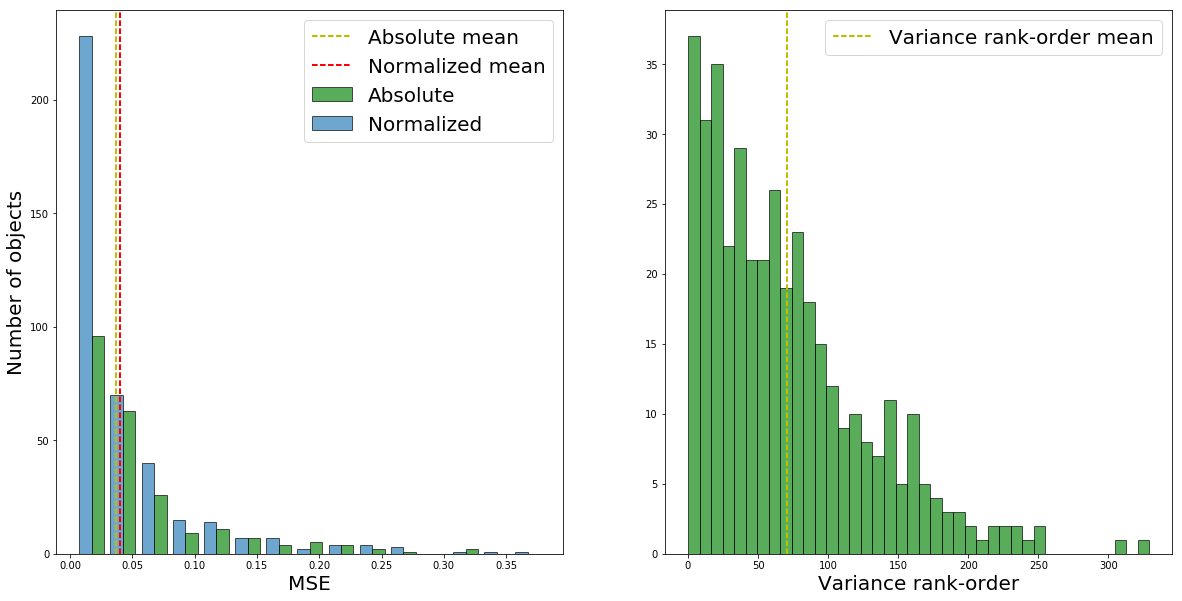

In [434]:
plot_graphs(predicts, y)

#### Модель №2

Используется word2vec, обученный на **Национальном Корпусе Русского Языка и Википедии** от "января 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 600 миллионов слов |
| Частотный порог | 15 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 20 |

In [436]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/ruwikiruscorpora.bin', binary=True)

In [437]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [438]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0411610078923

Абсолютные предсказания: 
0.0509819300554

Spearman rank correlation: 
0.641340046202


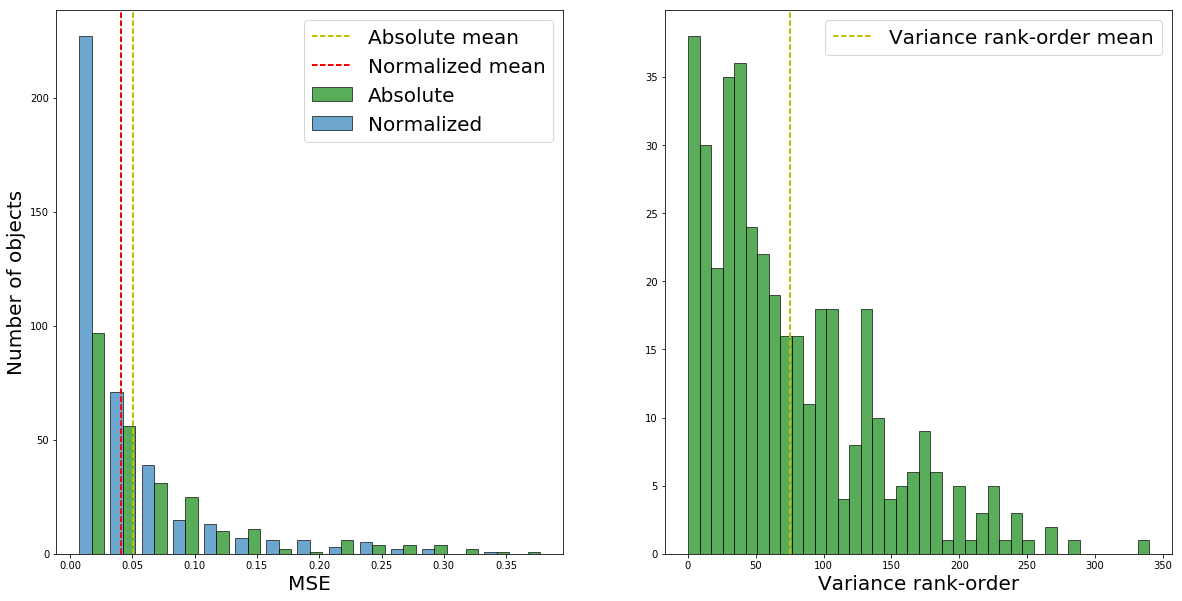

In [439]:
plot_graphs(predicts, y)

#### Модель №3

Используется word2vec, обученный на **Веб-корпусе** от "декабрь 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 900 миллионов слов |
| Частотный порог | 30 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 20 |

In [441]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/web.bin', binary=True)

In [442]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [443]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0400544907362

Абсолютные предсказания: 
0.0539420002041

Spearman rank correlation: 
0.641116495043


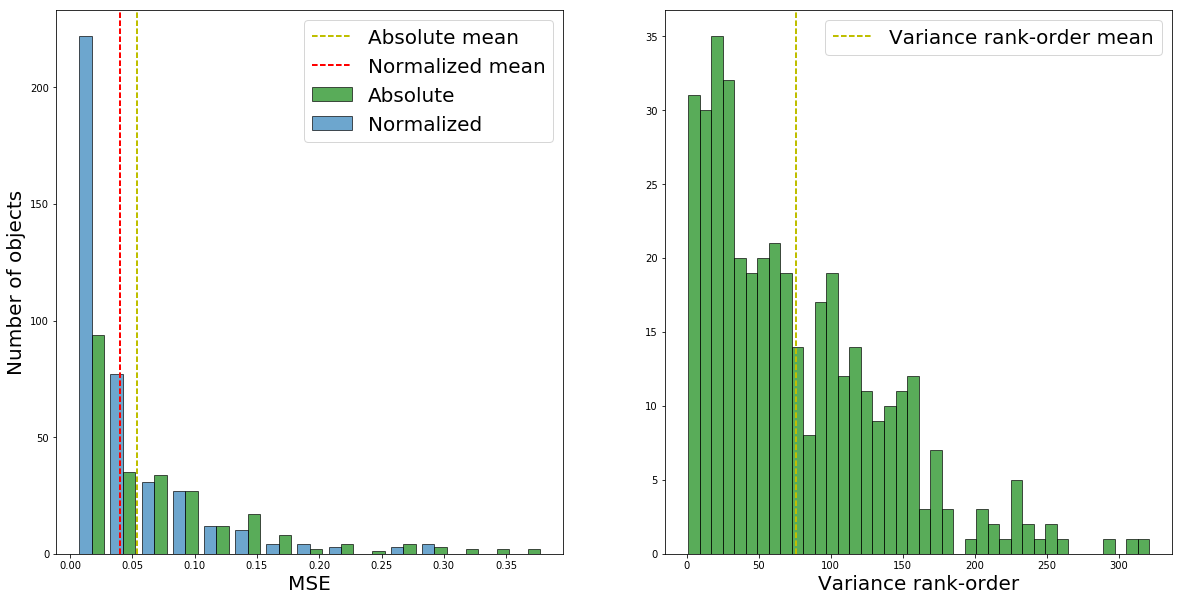

In [444]:
plot_graphs(predicts, y)

#### Модель №4

Используется word2vec, обученный на **Новостном корпусе** от "с сентября 2013 до ноября 2016". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 5 миллиардов слов |
| Частотный порог | 200 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 2 |

In [445]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/news.bin', binary=True)

In [446]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [447]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0489090111169

Абсолютные предсказания: 
0.0727769463928

Spearman rank correlation: 
0.589919280802


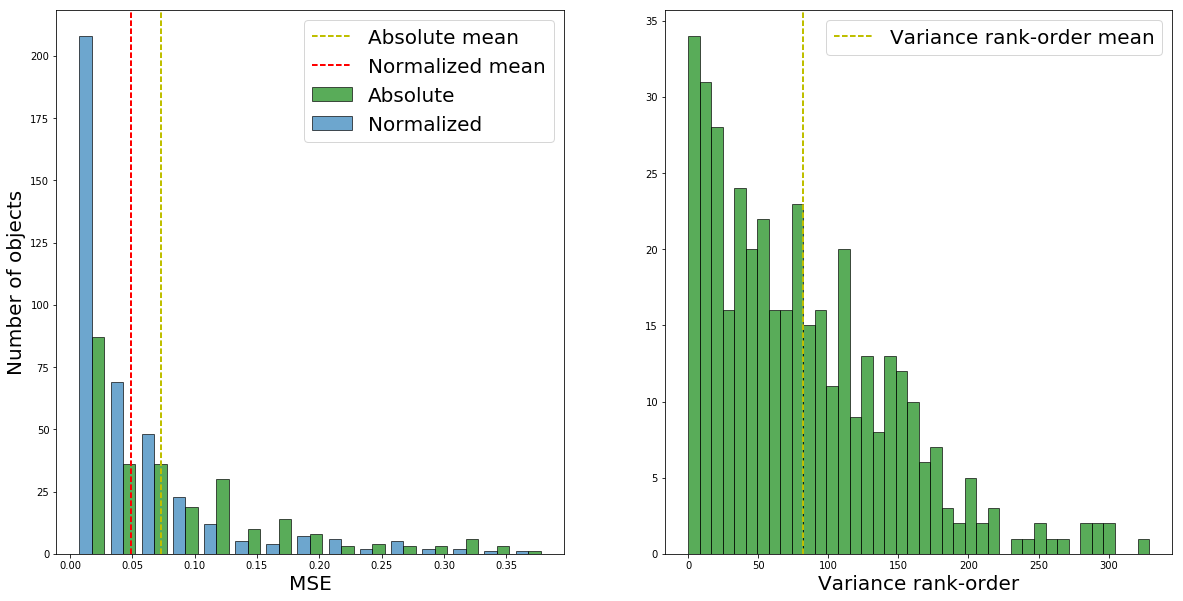

In [448]:
plot_graphs(predicts, y)

### Выводы по использованию различных готовых корпусов word2ec

|Корпус|Объем словаря|Частотный порог|Алгоритм|Размерность вектора|Размер окна|MSE + нормализация|MSE|Корреляция Спирмена|Кол-во ненайденных пар|
| :-: | :-: |:-: |:-: |:-: |:-: | :-: | :-: | :-: | :-: |
| НКРЯ | 250 миллионов слов | 10 | Skip-gramm | 300 | 10 | 0.04015 | 0.03680 | 0.68503 | 2 |
| Wiki | 600 миллионов слов | 15 | CBOW | 300 | 20 | 0.04116 | 0.05098 | 0.64134 | 2 |
| Web | 900 миллионов слов | 30 | CBOW | 300 | 20 | 0.04005 | 0.05394 | 0.64112 | 2 |
| News | 5 миллиардов слов | 200 | CBOW | 300 | 2 | 0.04891 | 0.07278 | 0.58992 | 2 |

1. Основным критерием качесва мы выберем коэффициент ранговой корреляции Спирмена, так как главной целью нашего предсказания является ранжирование пар по семантической близости. Наилучший результат показал национальный корпус русского языка, наихудший - новостной.
<p>
<p>
2. Если смотреть на отклонения от значений, то можно сказать, что нормализация предсказаний дает сильное улучшение на большинстве корпусах. Это логично, так как одна максимально синонимичная пара, не входящая в тестовый датасет, уменьшает значения схожести другим парам. 
<p>
<p>
3. На данный момент мы не можем сказать, насколько сильно влияет выбор алгоритма (CBOW и Skip-gramm), размер окна и размер вектора, так как нет сравнений конкретно по каждому параметру, ипользуя один корпус.
<p>
<p>
4. И на последок, word2vec неплохо справляется со своей задачей. Постараемся улучшить качество, используя дополненительно  словари Тезаурус

### Создание своей модели Word2Vec

In [15]:
# Считывание из файла N слов и формирование предложение по 5000 символов в каждом
def getNwords(ffile, last_word='', N=1000000):
    words = []
    n_words = 0
    flag_EOF = False
    while (n_words < N):
        s = ffile.read(5000) # считываю по 5000 символов и разбиваю их на слова
        if len(s) < 5000:
            # если осталось < 5000 символов == конец файла
            s = last_word + s
            currently_words = s.split(' ')
            words.append(currently_words)
            flag_EOF = True
            break
            
        s = last_word + s
        currently_words = s.split(' ')
        n_words += len(currently_words) - 1
        words.append(currently_words[:-1])
        last_word = currently_words[-1]
        
    return words, last_word, flag_EOF

In [742]:
# разбиваем на пакеты по 10.000.000 слов и обучаем модель на очередной партии
file_text = open('./data/global_text.txt')
last_word = ''
model = gensim.models.word2vec.Word2Vec(iter=5, min_count=1, size=300, window=5)

i = 0
while(True):
    words, last_word, flag_EOF = getNwords(file_text, last_word, 10000000)
    
#     with open(os.path.join('./words/', str(i)), 'w') as output:
#         words_pickle = pickle.dumps(words)
#         output.write(words_pickle)

    if i == 0:
        model.build_vocab(words)
    else:
        model.build_vocab(words, update=True)
        model.train(words)
    
    print "Step: %d" %i
    i += 1
    
    if flag_EOF:
        break

Step: 0



KeyboardInterrupt



In [39]:
# проверка работы
for word in model.most_similar('ТИГР'):
    print word[0]

МЕДВЕДЬ
ОЛЕНЬ
ЛИС
ВОЛК
РЫСЬ
ЛОСЬ
ИРБИС
ХИЩНИК
ЗВЕРЬ
КОСУЛЯ


In [41]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict_myModel(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

5


In [40]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0493730887131

Абсолютные предсказания: 
0.0567040556829

Spearman rank correlation: 
0.556238059858


### Функции сохранения и загрузки результатов моделей

In [401]:
def save_result_model(algorithm, window, size, min_count, alpha, result, n_undefined, ttime, output_path):
    with open(output_path, 'a') as ofile:
        params = [algorithm, window, size, min_count, alpha]
        results = [result, n_undefined, ttime]
        pick = json.dumps({'params': params, 'result': results})
        ofile.write(pick)
        ofile.write('\n')
    print 'Saved'

In [402]:
def load_result_model(file_path):
    results = []
    with open(file_path) as ifile:
        for line in ifile:
            results.append(json.loads(line))
    return results

### Сравнение собственных моделей Word2Vec

In [18]:
def fil_model(algorithm, window, size, min_count, alpha):
    last_time = time.time()
    with open('./data/global_text.txt') as file_text:
        last_word = ''
        model = gensim.models.word2vec.Word2Vec(iter=5, sg=algorithm, window=window, size=size, min_count=min_count, alpha=alpha)

        i = 0
        while(True):
            words, last_word, flag_EOF = getNwords(file_text, last_word, 10000000)

            if i == 0:
                model.build_vocab(words)
            else:
                model.train(words)

            if i % 1 == 0:
                print "Step: %d" %i
            i += 1

            if flag_EOF:
                break
    return model, (time.time() - last_time) / 60

In [19]:
def result_model(model, ttime):
    result = []
    predicts, undefinded = predict_myModel(model, data)
    result.append(spearmanr(predicts, y).correlation)
    result.append(len(undefinded))
    result.append(ttime)
    
    return result

In [398]:
def plot_feature(result, param):
    params_id =  {'algorithm' : 0, 
                  'window': 1, 
                  'size' : 2,
                  'min_count' : 3,
                  'alpha' : 4
                 }
    res = []
    ids = []
    ttimes = []
    for a in result:
        res.append(a['result'][0])
        ids.append(a['params'][params_id[param]])
        ttimes.append(a['result'][2])
        
    plt.figure(figsize=(10, 20))
    f, axx = plt.subplots(1,2, figsize=(20,10))
    axx[0].plot(ids,res)
    axx[1].plot(ids, ttimes)
    plt.show()

#### Сравнение по ширине окна

In [399]:
algorithm = 0 # CBOW
size = 300
min_count = 1
alpha = 0.025
# __ testee __
windows = range(1, 30, 2)

for window in windows:
    model, ttime = fil_model(algorithm, window, size, min_count, alpha)
    result = result_model(model, ttime)
    
    save_result_model(algorithm, window, size, min_count, alpha, result[0], result[1], result[2], './results/windowsCBOW')

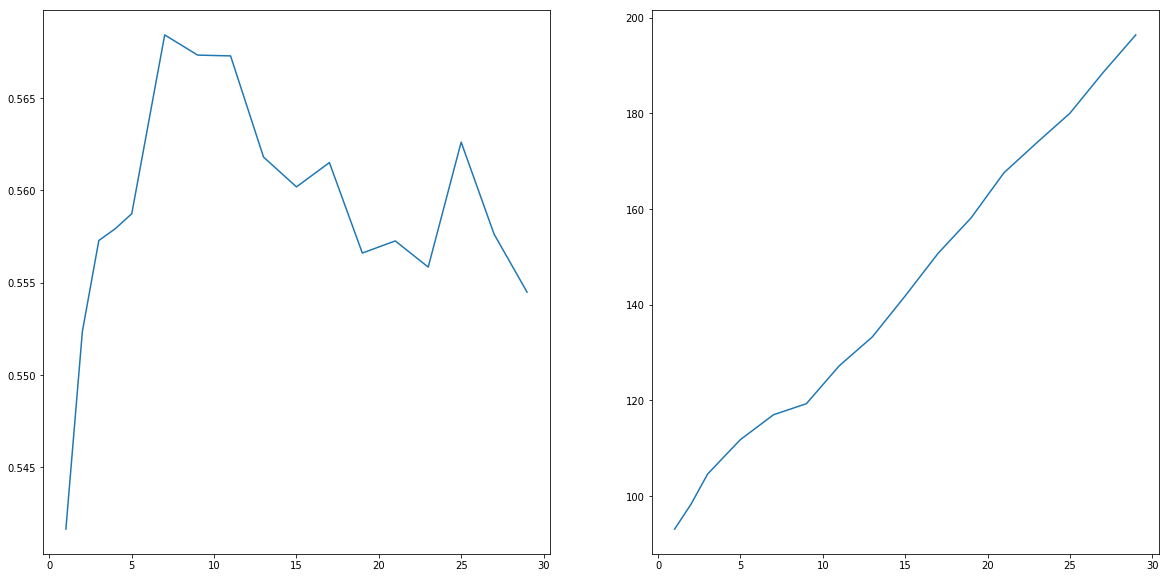

In [412]:
my_result = load_result_model('./results/windowsCBOW')
plot_feature(my_result, 'window')

#### Сравнение по ширине окна Skip-gramm

In [407]:
algorithm = 1 # Skip-gramm
size = 300
min_count = 1
alpha = 0.025
# __ testee __
windows = range(1, 30, 30)

for window in windows:
    model, ttime = fil_model(algorithm, window, size, min_count, alpha)
    result = result_model(model, ttime)
    
    save_result_model(algorithm, window, size, min_count, alpha, result[0], result[1], result[2], './results/windowsSg')

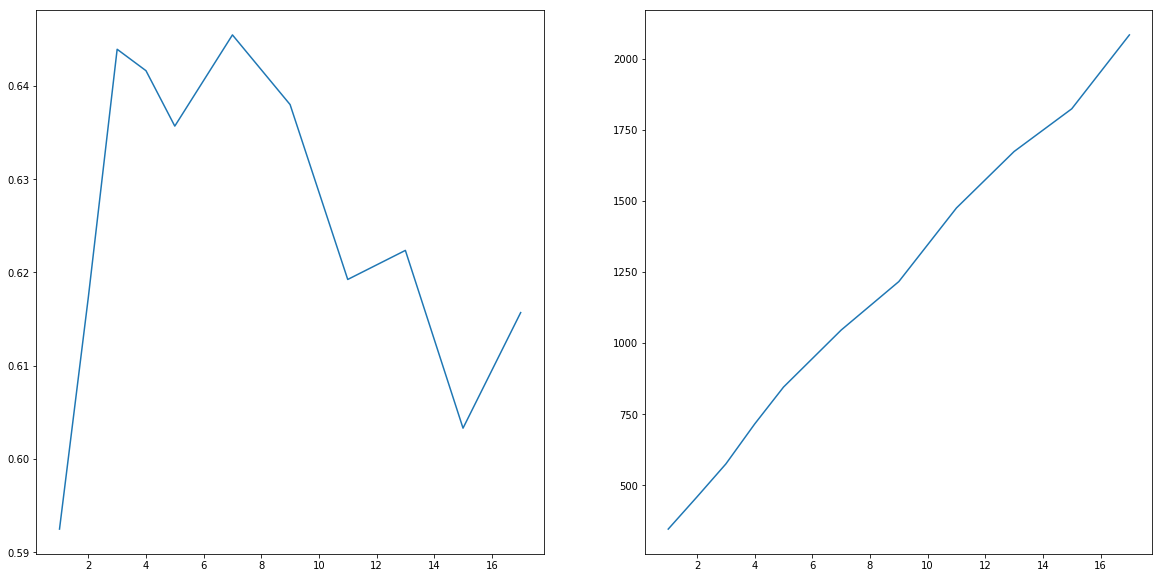

In [415]:
my_result = load_result_model('./results/windowsSg')
plot_feature(my_result, 'window')

#### Сравнение по размеру вектора CBOW

In [ ]:
algorithm = 0 # CBOW
window = 7
min_count = 1
alpha = 0.025
# __ testee __
sizes = range(200, 400, 15)

for size in sizes:
    model, ttime = fil_model(algorithm, window, size, min_count, alpha)
    result = result_model(model, ttime)
    
    save_result_model(algorithm, window, size, min_count, alpha, result[0], result[1], result[2], './results/sizeCBOW')

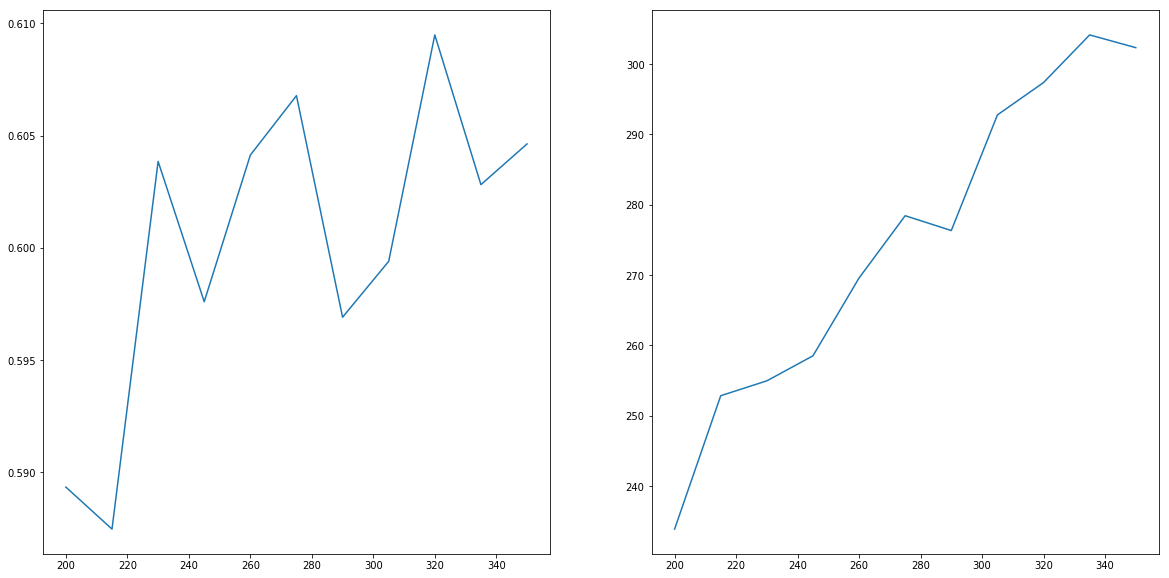

In [418]:
my_result = load_result_model('./results/sizeCBOW')
plot_feature(my_result, 'size')

#### Сравнение по размеру вектора Skip-gramm

In [ ]:
algorithm = 1 # Skip-gramm
window = 7
min_count = 1
alpha = 0.025
# __ testee __
sizes = range(200, 400, 15)

for size in sizes:
    model, ttime = fil_model(algorithm, window, size, min_count, alpha)
    result = result_model(model, ttime)
    
    save_result_model(algorithm, window, size, min_count, alpha, result[0], result[1], result[2], './results/sizeSg')

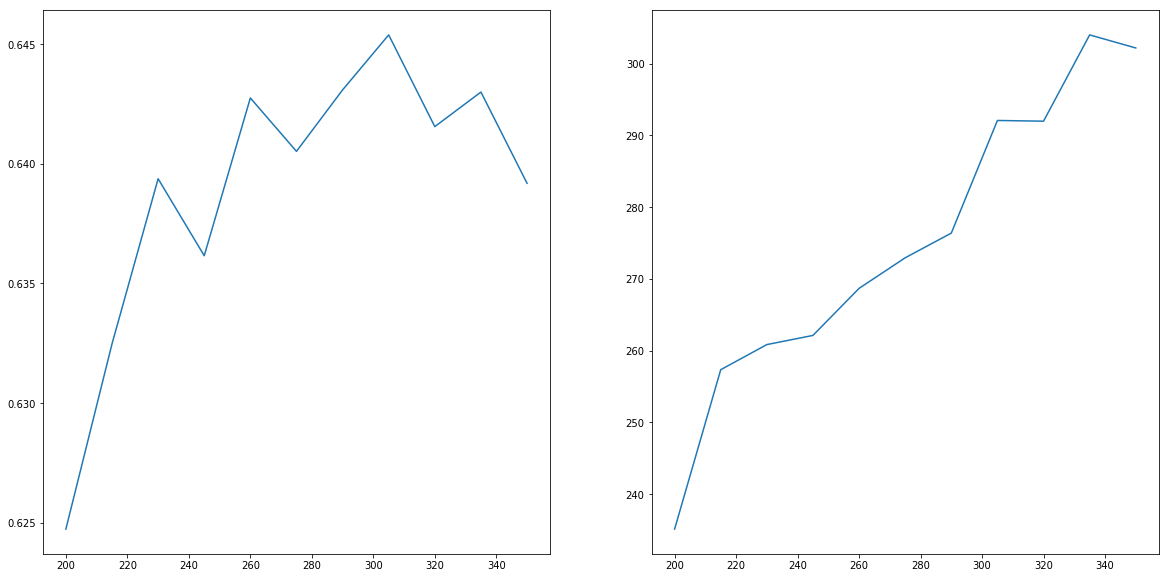

In [425]:
my_result = load_result_model('./results/sizeSg')
plot_feature(my_result, 'size')

### Итоговая модель

In [329]:
model = gensim.models.Word2Vec.load('./myModel/myModel')

### Создание необходимых словарей для формирования графа связности слов по тезаурусу

In [16]:
path_tezaurus = './tezaurus/ruthes2017/'

##### Формированиеи словарей "название понятия - id" и "id - название понятия"

In [17]:
# __ Достаем из строки id __
def extract_id(line):
    tmp = line.strip().split('id="')
    
    # __ если найден "concept id" __
    if len(tmp) == 2:
        return tmp[1].split('">')[0]
    # __ если не найден __
    else:
        return None

In [18]:
print extract_id('  <concept id="1342">    ')
print extract_id('  <entry id="100001">    ')
print extract_id('  <asdfasfasdf="100001">    ')

1342
100001
None


In [19]:
# __ Убираем пояснения __
def del_clarification(name):
    # __ убираем пояснения в скобках __
    name = name.strip().split('(')[0]
    
    # __ убираем пояснения после запятой __
    name = name.strip().split(',')[0]

    # __ если есть точка, удаляем её __
    name = name.strip().replace('\\.', '')

    return name

In [20]:
# __ Оставляем только однословные понятия __
def filter_name(name):
    name = name.decode('utf-8')
    name = del_clarification(name)
    tmp = name.strip().split(' ')
    
    # __ если слово состоит из нескольких слов, то не берем его __
    if len(tmp) > 1:
        return None
    else:
        return tmp[0]

In [21]:
# __ Получаем из строеки название понятия __
def extract_name(line):
    tmp = line.strip().split('<name>')
    
    # __ если найден "name" __
    if len(tmp) == 2:
        return filter_name(tmp[1].split('</name>')[0])
    # __ если не найден __
    else:
        return None

In [22]:
print extract_name('   <name>БАНК (ФИНАНСОВОЕ УЧРЕЖДЕНИЕ), ЗДАНИЕ</name>')

БАНК


In [23]:
# __ Составляем словари id – name и name – id __
def create_concepts_dict(path, file_name):
    concepts = {}
    name_id = {}
    with open(os.path.join(path, file_name)) as fconcept:
        conc_id = -1
        name = ''
        
        for line in fconcept:

            tmp = extract_id(line)
            # __ если строка содержит id __
            if tmp:
                conc_id = tmp
                continue

            tmp = extract_name(line)
            # __ если строка содержит имя __ 
            if tmp:
                name = tmp
                if name not in name_id:
                    concepts[conc_id] = name
                    name_id[name] = conc_id
                
    return concepts, name_id

In [24]:
# __ словарь понятий __
concepts, concept_name_id = create_concepts_dict(path_tezaurus, 'concepts.xml')
print len(concepts)

17228


In [25]:
# __ словарь входных слов __
entry, entry_name_id = create_concepts_dict(path_tezaurus, 'text_entry.xml')
print len(entry)

58139


In [26]:
# __ Объединение понятий и входных слов __
id_name = {}
for item in concepts.items():
    id_name['conc_' + item[0]] = item[1]
    
for item in entry.items():
    id_name['ent_' + item[0]] = item[1]

In [27]:
name_id = {}
for item in concept_name_id.items():
    name_id.setdefault(item[0], {})
    name_id[item[0]]['cons'] = 'conc_' + item[1]
for item in entry_name_id.items():
    name_id.setdefault(item[0], {})
    name_id[item[0]]['ent'] = 'ent_' + item[1]

In [28]:
print len(id_name)
print len(name_id)

75367
58735


In [29]:
# __ Список слов, не найденных в тезаурусе __

values = concepts.values()
values2 = entry.values()

undefined_tezaurus = set()
k = 0
for word in data['word1']:
    w = word.strip().decode('utf8').upper()
    if (w not in values) and (w not in values2):
        undefined_tezaurus.add(word)
for word in data['word2']:
    w = word.strip().decode('utf8').upper()
    if (w not in values) and (w not in values2):
        undefined_tezaurus.add(word) 
        
for word in undefined_tezaurus:
    print word
print 
print len(undefined_tezaurus)

сто
пять
джексон
фрейд
наличные
морепродукт
марадона
арафат
приcпособление
блядь
омар
джин
cреда
новости
фбр
cознание
йель
cd
семь
опек

20


##### Формированиеи словарей синонимов и отношений

In [30]:
# __ Получение id двух синонимов из строки __
def extract_synonyms(line):
    tmp = line.strip().split('concept_id="')[1].split('" entry_id="')
    word1 = tmp[0]
    word2 = tmp[1].split('"/>')[0]
    return word1, word2

In [31]:
# __ Составляем словарь id - список id синонимов __ 
def create_synonym_dict(path, file_name):
    synonyms = {}
    with open(os.path.join(path, file_name)) as ffile:
        for line in ffile:
            if line.strip() != '<synonyms>' and line.strip() != '</synonyms>':
                word1, word2 = extract_synonyms(line)
                synonyms.setdefault('conc_' + word1, []).append('ent_' + word2)
                synonyms.setdefault('ent_' + word2, []).append('conc_' + word1)
    return synonyms

In [32]:
# __ Словарь синонимов __
synonyms = create_synonym_dict(path_tezaurus, 'synonyms.xml')

In [33]:
print synonyms['conc_110139']
print synonyms['ent_109601']

['ent_134839', 'ent_140303', 'ent_157210', 'ent_161016', 'ent_161651', 'ent_161653', 'ent_184378', 'ent_184379', 'ent_191205', 'ent_194424', 'ent_197247']
['conc_3']


In [34]:
# __ Получение двух id из отношения __
def extract_relation(line):
    tmp = line.strip().split('from="')[1].split('" to="')
    word1 = tmp[0]
    word2 = tmp[1].split('" name="')[0]
    return word1, word2

In [35]:
# __ Составляем словарь id - список id слов, имеющих отношение к первому __
def create_relation_dict(path, file_name):
    relations = {}
    with open(os.path.join(path, file_name)) as ffile:
        for line in ffile:
            if line.strip() != '<relations>' and line.strip() != '</relations>':
                word1, word2 = extract_relation(line)
                relations.setdefault('conc_' + word1, []).append('conc_' + word2)
#                 relations.setdefault('conc_' + word2, []).append('conc_' + word1)
    return relations

In [36]:
# __ Словарь отношений __
relations = create_relation_dict(path_tezaurus, 'relations.xml')

In [37]:
print relations['conc_1']

['conc_4', 'conc_5', 'conc_14', 'conc_462', 'conc_2069', 'conc_2091', 'conc_2285', 'conc_5308', 'conc_6050', 'conc_7496', 'conc_8669', 'conc_8971', 'conc_130004', 'conc_133163', 'conc_133853', 'conc_133997', 'conc_135291', 'conc_143559', 'conc_145728']


In [38]:
def get_syninyms(name):
    tmp = []
    if name in name_id:
        if 'cons' in name_id[name] and name_id[name]['cons'] in synonyms:
            tmp = filter(lambda x: x in id_name, synonyms[name_id[name]['cons']])
        if 'ent' in name_id[name] and name_id[name]['ent'] in synonyms:
            tmp.extend(filter(lambda x: x in id_name, synonyms[name_id[name]['ent']]))
        return map(lambda x: id_name[x], tmp)
    else:
        return []

In [39]:
def get_relations(name):
    if name in name_id and 'cons' in name_id[name] and name_id[name]['cons'] in relations:
        tmp = filter(lambda x: x in id_name, relations[name_id[name]['cons']])
        return map(lambda x: id_name[x], tmp)
    else:
        return []

In [40]:
for relat in get_syninyms(u'ВОЛШЕБНИК'):
    print relat

print 
print 'Synonyms:'
print
for syn in get_syninyms(u'МАГ'):
    print syn
    
print 
print 'Relations:'
print
for relat in get_relations(u'ВОЛШЕБНИК'):
    print relat

ВОЛШЕБНИК
КОЛДУН
ЧАРОДЕЙ
МАГ
ЧАРОДЕЙСКИЙ
КОЛДУНЬЯ
КУДЕСНИК
КУДЕСНИЧЕСКИЙ
ВЕДЬМАК
ЧУДЕСНИК
ВЕДУН
ВОЛШЕБНИК

Synonyms:

ВОЛШЕБНИК

Relations:

ВОЛШЕБНИЦА
ГАДАЛКА
КОЛДОВСТВО
ШАМАН


### Класс: Retrofitting

Модель retrofitting преобразует вектора, полученные при помощи word2vec, используя знания отношений слов из словаря Тезаурус

In [470]:
class Retrofitting():
    def __init__(self, n_iter=5, alpha=1.0, betta=0.1, coef_relat=0.3, type_corp='rusCorp'):
        self.n_iter = n_iter  # __ количество итераций алгоритма fit __
        self.alpha = alpha
        self.betta = betta
        self.coef_relat = coef_relat
        self.type_corp = type_corp
        
    def fit(self, model, id_name, name_id, synonyms, relations):
        self.model = model
        # __ получение для каждого слова его вектор из word2vec и инициализация обновленных векторв __
        name_w2v = {}
        name_fitted = {}
        for (name, id_word) in name_id.items():
            w2v = []
            try:
                if self.type_corp == 'rusCorp':
                    w2v = model.word_vec(normal_analizer.norm(name.lower().encode('utf8')))
                else:
                    w2v = model.wv[name.encode('utf8')]
            except:
                pass
            if len(w2v) != 0:
                name_w2v[name] = w2v.copy()
                name_fitted[name] = w2v.copy()
        
        # __ итерации алгоритма __
        for step in xrange(self.n_iter):
            tmp_name_fitted = {}
            i = 0
            for name in name_w2v.keys():
                sum_syn_betta = 0
                sum_betta = 0
                            
                if 'cons' in name_id[name]:
                    count_syns = 0
                    for synonym in synonyms[name_id[name]['cons']]:
                        if synonym in id_name and id_name[synonym] in name_fitted:
                            count_syns += 1
                    if count_syns != 0:
                        betta = 1.0 / count_syns
                    for synonym in synonyms[name_id[name]['cons']]:
                        if synonym in id_name and id_name[synonym] in name_fitted:
                            sum_syn_betta += self.betta * betta * name_fitted[id_name[synonym]]
                            sum_betta += self.betta * betta
                            
                if 'ent' in name_id[name]:
                    count_syns = 0
                    for synonym in synonyms[name_id[name]['ent']]:
                        if synonym in id_name and id_name[synonym] in name_fitted:
                            count_syns += 1
                    if count_syns != 0:
                        betta = 1.0 / count_syns
                    for synonym in synonyms[name_id[name]['ent']]:
                        if synonym in id_name and id_name[synonym] in name_fitted:
                            sum_syn_betta += self.betta * betta * name_fitted[id_name[synonym]]
                            sum_betta += self.betta * betta
                        
                # __ учитываем отношения __
                if 'cons' in name_id[name]:
                    count_relat = 0
                    for relation in relations[name_id[name]['cons']]:
                        if relation in id_name and id_name[relation] in name_fitted:
                            count_relat += 1
                    if count_relat != 0:
                        betta = 1.0 / count_relat
                    for relation in relations[name_id[name]['cons']]:
                        if relation in id_name and id_name[relation] in name_fitted:
                            sum_syn_betta += self.betta * self.coef_relat * betta * name_fitted[id_name[relation]]
                            sum_betta += self.betta * self.coef_relat  * betta
                            
                tmp_name_fitted[name] = (sum_syn_betta + self.alpha * name_w2v[name]) / (sum_betta + self.alpha)
                
            name_fitted = tmp_name_fitted.copy()
        
        self.name_fitted = name_fitted.copy()
        return self
    
    def similarity(self, word1, word2):
        word1 = word1.decode('utf8')
        word2 = word2.decode('utf8')
        if word1 in self.name_fitted and word2 in self.name_fitted:
            word1_vec = self.name_fitted[word1]
            word2_vec = self.name_fitted[word2]
            return 1 - spatial.distance.cosine(word1_vec, word2_vec)
        else:
            try:
                if self.type_corp == 'rusCorp':
                    value = self.model.similarity(normal_analizer.norm(word1.lower().encode('utf8')), normal_analizer.norm(word2.lower().encode('utf8')))
                else:
                    value = self.model.similarity(word1.encode('utf8'), word2.encode('utf8'))
                return value
            except:
                return 0

### Тест на разных корпусах

    1. Собственный корпус

In [471]:
model = gensim.models.Word2Vec.load('./myModel/myModel')

In [472]:
retrofitting = Retrofitting(type_corp='my')
retrofitting = retrofitting.fit(model, id_name, name_id, synonyms, relations)

In [473]:
#  __ Предсказания модели с постобучением __
predicts, undefinded = predict_myModel(retrofitting, data)
print_accuracy(np.array(predicts), y)

Нормализованные предсказания: 
0.0562254908466

Абсолютные предсказания: 
0.0492591884369

Spearman rank correlation: 
0.65148741098


In [474]:
#  __ Предсказания только word2vec __
predicts, undefinded = predict_myModel(model, data)
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0601722370905

Абсолютные предсказания: 
0.0561642789093

Spearman rank correlation: 
0.645451619434


    2. НКРЯ

In [475]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/ruscorpora.bin', binary=True)

In [476]:
retrofitting = Retrofitting()
retrofitting = retrofitting.fit(model, id_name, name_id, synonyms, relations)

In [477]:
#  __ Предсказания модели с постобучением __
predicts, undefinded = predict_myModel(retrofitting, data)
print_accuracy(np.array(predicts), y)

Нормализованные предсказания: 
0.0381463818612

Абсолютные предсказания: 
0.0342830399711

Spearman rank correlation: 
0.691371233592


In [478]:
#  __ Предсказания только word2vec __
predicts, undefinded = predict(model, data)
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.040152472329

Абсолютные предсказания: 
0.0367998209608

Spearman rank correlation: 
0.68503439607


    3. Веб

In [479]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/web.bin', binary=True)

In [480]:
retrofitting = Retrofitting()
retrofitting = retrofitting.fit(model, id_name, name_id, synonyms, relations)

In [481]:
#  __ Предсказания модели с постобучением __
predicts, undefinded = predict_myModel(retrofitting, data)
print_accuracy(np.array(predicts), y)

Нормализованные предсказания: 
0.0389179510811

Абсолютные предсказания: 
0.0505310898752

Spearman rank correlation: 
0.650160796072


In [482]:
#  __ Предсказания только word2vec __
predicts, undefinded = predict(model, data)
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0400544907362

Абсолютные предсказания: 
0.0539420002041

Spearman rank correlation: 
0.641116495043


    4. НКРЯ + wiki

In [483]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/ruwikiruscorpora.bin', binary=True)

In [484]:
retrofitting = Retrofitting(coef_relat=0.3)
retrofitting = retrofitting.fit(model, id_name, name_id, synonyms, relations)

In [485]:
#  __ Предсказания модели с постобучением __
predicts, undefinded = predict_myModel(retrofitting, data)
print_accuracy(np.array(predicts), y)

Нормализованные предсказания: 
0.0401207449543

Абсолютные предсказания: 
0.0489251322979

Spearman rank correlation: 
0.644560496782


In [486]:
#  __ Предсказания только word2vec __
predicts, undefinded = predict(model, data)
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0411610078923

Абсолютные предсказания: 
0.0509819300554

Spearman rank correlation: 
0.641340046202


    5. Новостной

In [487]:
model = gensim.models.KeyedVectors.load_word2vec_format('./courps/news.bin', binary=True)

In [488]:
retrofitting = Retrofitting(coef_relat=0.3)
retrofitting = retrofitting.fit(model, id_name, name_id, synonyms, relations)

In [489]:
#  __ Предсказания модели с постобучением __
predicts, undefinded = predict_myModel(retrofitting, data)
print_accuracy(np.array(predicts), y)

Нормализованные предсказания: 
0.0473420930475

Абсолютные предсказания: 
0.0689142492816

Spearman rank correlation: 
0.597976738661


In [490]:
#  __ Предсказания только word2vec __
predicts, undefinded = predict(model, data)
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0489090111169

Абсолютные предсказания: 
0.0727769463928

Spearman rank correlation: 
0.589919280802


### Сравнение полученных результатов

                                            Retrofitting vs just Word2Vec

|Модель|MSE + нормализация|MSE|Корреляция Спирмена|Кол-во ненайденных пар|
| :-: | :-: |:-: |:-: |:-: |
|My| 0.05623 vs 0.06017 |0.04926 vs 0.05616 | 0.65149 vs 0.64545 | 5 |
| НКРЯ | 0.03814 vs 0.04015 | 0.03428 vs 0.03680 | 0.69137 vs 0.68503 | 2 |
| НКРЯ + wiki |0.03973 vs 0.04116 |0.04824 vs 0.05098  |0.64456 vs 0.64134 | 2 |
| Веб |0.03892 vs 0.04005 |0.05053 vs 0.05394 |0.65016 vs 0.64112 | 2 |
| Новости |0.04698 vs 0.04891 |0.06763 vs 0.07278  |0.59986 vs 0.58992 | 2 |
